In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, RFECV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Задание 1

In [3]:
heros = pd.read_csv(f'../lab4/Constants.Heroes.csv')
heros

,Unnamed: 0,id,name,primary_attr,attack_type,roles,img,icon,base_health,base_health_regen,...,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,cm_enabled,legs,day_vision,night_vision,localized_name
0,0,1,npc_dota_hero_antimage,agi,Melee,"['Carry', 'Escape', 'Nuker']",/apps/dota2/images/dota_react/heroes/antimage....,/apps/dota2/images/dota_react/heroes/icons/ant...,120,1.00,...,1.4,100,0.30,310,NaN,True,2,1800,800,Anti-Mage
1,1,2,npc_dota_hero_axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",/apps/dota2/images/dota_react/heroes/axe.png?,/apps/dota2/images/dota_react/heroes/icons/axe...,120,2.50,...,1.7,100,0.40,315,NaN,True,2,1800,800,Axe
2,2,3,npc_dota_hero_bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",/apps/dota2/images/dota_react/heroes/bane.png?,/apps/dota2/images/dota_react/heroes/icons/ban...,120,0.25,...,1.7,100,0.30,305,NaN,True,4,1800,1200,Bane
3,3,4,npc_dota_hero_bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",/apps/dota2/images/dota_react/heroes/bloodseek...,/apps/dota2/images/dota_react/heroes/icons/blo...,120,0.25,...,1.7,100,0.43,285,NaN,True,2,1800,800,Bloodseeker
4,4,5,npc_dota_hero_crystal_maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",/apps/dota2/images/dota_react/heroes/crystal_m...,/apps/dota2/images/dota_react/heroes/icons/cry...,120,0.25,...,1.7,100,0.45,280,NaN,True,2,1800,800,Crystal Maiden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,121,135,npc_dota_hero_dawnbreaker,str,Melee,"['Carry', 'Durable']",/apps/dota2/images/dota_react/heroes/dawnbreak...,/apps/dota2/images/dota_react/heroes/icons/daw...,120,0.50,...,1.7,100,0.46,300,0.6,True,2,1800,800,Dawnbreaker
122,122,136,npc_dota_hero_marci,all,Melee,"['Support', 'Carry', 'Initiator', 'Disabler', ...",/apps/dota2/images/dota_react/heroes/marci.png?,/apps/dota2/images/dota_react/heroes/icons/mar...,120,0.25,...,1.7,100,0.30,315,0.9,True,2,1800,800,Marci
123,123,137,npc_dota_hero_primal_beast,str,Melee,"['Initiator', 'Durable', 'Disabler']",/apps/dota2/images/dota_react/heroes/primal_be...,/apps/dota2/images/dota_react/heroes/icons/pri...,120,0.25,...,1.8,100,0.60,305,0.6,True,2,1800,800,Primal Beast
124,124,138,npc_dota_hero_muerta,int,Ranged,"['Carry', 'Nuker', 'Disabler']",/apps/dota2/images/dota_react/heroes/muerta.png?,/apps/dota2/images/dota_react/heroes/icons/mue...,120,0.25,...,1.7,115,0.35,295,0.7,True,2,1800,800,Muerta


In [4]:
df = pd.concat(pd.read_csv(f'../lab2/20250{i}/players.csv') for i in range(1,5))
df

C:\Users\Roma\AppData\Local\Temp\ipykernel_24164\3887877372.py:1: DtypeWarning: Columns (148) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(pd.read_csv(f'../lab2/20250{i}/players.csv') for i in range(1,5))
C:\Users\Roma\AppData\Local\Temp\ipykernel_24164\3887877372.py:1: DtypeWarning: Columns (51,52,128,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(pd.read_csv(f'../lab2/20250{i}/players.csv') for i in range(1,5))


,player_slot,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,...,purchase_rapier,match_id,leagueid,performance_others,additional_units,repicked,hero_variant,neutral_tokens_log,neutral_item_history,item_neutral2
0,0,0.0,0.0,4.0,2.0,1.0,0.0,0.863636,0.0,0.0,...,NaN,8107483721,17163,NaN,NaN,NaN,1.0,"[{'time': 433, 'key': 'Tier1Token'}, {'time': ...",NaN,NaN
1,1,2.0,0.0,3.0,1.0,5.0,0.0,0.636364,3.0,0.0,...,NaN,8107483721,17163,NaN,NaN,NaN,1.0,"[{'time': 1918, 'key': 'Tier3Token'}]",NaN,NaN
2,2,0.0,0.0,6.0,2.0,7.0,0.0,0.227273,2.0,1.0,...,NaN,8107483721,17163,NaN,NaN,NaN,1.0,"[{'time': 473, 'key': 'Tier1Token'}, {'time': ...",NaN,NaN
3,3,9.0,12.0,66.0,12.0,1.0,0.0,0.227273,0.0,0.0,...,NaN,8107483721,17163,NaN,NaN,NaN,1.0,[],NaN,NaN
4,4,4.0,5.0,43.0,7.0,3.0,0.0,0.818182,1.0,0.0,...,NaN,8107483721,17163,NaN,NaN,NaN,1.0,[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6415,128,3.0,2.0,8.0,3.0,0.0,0.0,0.400000,0.0,0.0,...,NaN,8245079060,17211,NaN,NaN,NaN,3.0,[],"[{'time': 488, 'item_neutral': 'mana_draught',...",1586.0
6416,129,0.0,0.0,0.0,0.0,3.0,0.0,0.266667,0.0,0.0,...,NaN,8245079060,17211,NaN,NaN,NaN,1.0,[],"[{'time': 450, 'item_neutral': 'polliwog_charm...",1577.0
6417,130,1.0,1.0,3.0,1.0,2.0,0.0,0.333333,1.0,0.0,...,NaN,8245079060,17211,NaN,NaN,NaN,2.0,[],"[{'time': 458, 'item_neutral': 'spark_of_coura...",1594.0
6418,131,2.0,0.0,0.0,0.0,11.0,0.0,0.866667,2.0,0.0,...,NaN,8245079060,17211,NaN,NaN,NaN,1.0,[],"[{'time': 461, 'item_neutral': 'trusty_shovel'...",1583.0


# Задание 2

In [13]:
def extract_teams(group):
    radiant = group[group['player_slot'] < 64].sort_values('player_slot')['hero_id'].tolist()
    dire    = group[group['player_slot'] >= 64].sort_values('player_slot')['hero_id'].tolist()
    return pd.Series({
        'radiant_heroes': radiant,
        'dire_heroes': dire,
        'radiant_win': group['radiant_win'].iloc[0]
    })

def synergy(line):
    wr_radiant, wr_dire = 0.0, 0.0
    
    # Для Radiant
    for hero1, hero2 in combinations(sorted(line['radiant_heroes']), 2):
        # Исправлено: безопасное получение винрейта (если пара отсутствует, используется 0.5)
        pair_data = winrate_df[(winrate_df['hero1'] == hero1) & (winrate_df['hero2'] == hero2)]
        wr = pair_data['winrate'].values[0] if not pair_data.empty else 0.5
        wr_radiant += wr
    
    # Для Dire
    for hero1, hero2 in combinations(sorted(line['dire_heroes']), 2):
        pair_data = winrate_df[(winrate_df['hero1'] == hero1) & (winrate_df['hero2'] == hero2)]
        wr = pair_data['winrate'].values[0] if not pair_data.empty else 0.5
        wr_dire += wr
    
    return pd.Series({'wr_radiant': wr_radiant, 'wr_dire': wr_dire})


def hero_melee(line):
    melee_radiant, melee_dire = 0, 0
    agi_radiant, int_radiant, str_radiant =0,0,0
    agi_dire, int_dire, str_dire =0,0,0
    for hero in line['radiant_heroes']:
        hero_data = heros[heros['id'] == hero].iloc[0]
        melee_radiant += 1 if hero_data['attack_type'] == 'Melee' else 0
        agi_radiant += 1 if hero_data['primary_attr'] == 'agi' else 0
        int_radiant += 1 if hero_data['primary_attr'] == 'int' else 0
        str_radiant += 1 if hero_data['primary_attr'] == 'str' else 0

    for hero in line['dire_heroes']:
        hero_data = heros[heros['id'] == hero].iloc[0]

        melee_dire += 1 if hero_data['attack_type'] == 'Melee' else 0
        agi_dire += 1 if hero_data['primary_attr'] == 'agi' else 0
        int_dire += 1 if hero_data['primary_attr'] == 'int' else 0
        str_dire += 1 if hero_data['primary_attr'] == 'str' else 0

    return pd.Series({'melee_radiant': melee_radiant, 
                      'agi_radiant': agi_radiant,
                      'int_radiant': int_radiant, 
                      'str_radiant': str_radiant,
                      'melee_dire': melee_dire, 
                      'agi_dire': agi_dire,
                      'int_dire': int_dire, 
                      'str_dire': str_dire,})

In [14]:
df = df[['match_id', 'hero_id', 'player_slot', 'radiant_win']]
data = df.copy()
data['team'] = data['player_slot'].apply(lambda x: 'radiant' if x < 128 else 'dire')
grouped = data.groupby(['match_id', 'team'])['hero_id'].apply(list).reset_index()
results = []
for _, row in grouped.iterrows():
    match_id = row['match_id']
    team = row['team']
    heroes = row['hero_id']
    # Получаем результат матча для команды
    radiant_win = df.loc[df['match_id'] == match_id, 'radiant_win'].values[0]
    win = 1 if (team == 'radiant' and radiant_win) or (team == 'dire' and not radiant_win) else 0
    
    # Генерируем уникальные пары героев (с сортировкой)
    for hero1, hero2 in combinations(sorted(heroes), 2):
        results.append((hero1, hero2, win, 1))

results_df = pd.DataFrame(results, columns=['hero1', 'hero2', 'win', 'total'])
winrate_df = results_df.groupby(['hero1', 'hero2']).agg(
    total_matches=('total', 'sum'),
    wins=('win', 'sum')
).reset_index()

winrate_df['winrate'] = winrate_df['wins'] / winrate_df['total_matches']

# Сортируем по убыванию винрейта
winrate_df = winrate_df.sort_values(by='winrate', ascending=False)
matches = df.groupby('match_id').apply(extract_teams).reset_index(drop=True)
matches[['wr_radiant', 'wr_dire']] = matches.apply(synergy, axis=1)
matches[['melee_radiant', 
         'wr_agi_radiantdire',
         'int_radiant',
         'str_radiant',
         'melee_dire',
         'agi_dire',
         'int_dire',
         'str_dire']] = matches.apply(hero_melee, axis=1)

# Собираем всех уникальных героев
all_heroes = sorted(
    set(matches['radiant_heroes'].explode().unique()) | 
    set(matches['dire_heroes'].explode().unique())
)

# Инициализируем бинаризатор
mlb = MultiLabelBinarizer(classes=all_heroes)

# Преобразуем списки героев в бинарные матрицы
X_radiant = mlb.fit_transform(matches['radiant_heroes'])
X_dire = mlb.transform(matches['dire_heroes'])

# Создаем DataFrame с признаками героев
hero_columns = [f"hero_{h}" for h in all_heroes]
df_radiant = pd.DataFrame(X_radiant, columns=[f"radiant_{c}" for c in hero_columns])
df_dire = pd.DataFrame(X_dire, columns=[f"dire_{c}" for c in hero_columns])

scaler = StandardScaler()
 
wr_scaled = scaler.fit_transform(matches[['wr_radiant', 'wr_dire','melee_radiant', 'wr_agi_radiantdire','int_radiant','str_radiant','melee_dire','agi_dire','int_dire','str_dire']])

# Создаем DataFrame для масштабированных признаков
df_wr = pd.DataFrame(wr_scaled, columns=['wr_radiant_scaled', 'wr_dire_scaled',
                                         'melee_radiant_scaled', 'wr_agi_radiantdire_scaled',
                                         'int_radiant_scaled','str_radiant_scaled','melee_dire_scaled',
                                         'agi_dire_scaled','int_dire_scaled','str_dire_scaled'])

numeric_features = ['wr_radiant_scaled', 'wr_dire_scaled',
                                         'melee_radiant_scaled', 'wr_agi_radiantdire_scaled',
                                         'int_radiant_scaled','str_radiant_scaled','melee_dire_scaled',
                                         'agi_dire_scaled','int_dire_scaled','str_dire_scaled']
# Объединяем все признаки
final_df = pd.concat([df_radiant, df_dire, df_wr, matches['radiant_win']], axis=1)
final_df = final_df.rename(columns={'radiant_win':'target'})
final_df

C:\Users\Roma\AppData\Local\Temp\ipykernel_24164\3563250493.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches = df.groupby('match_id').apply(extract_teams).reset_index(drop=True)


,radiant_hero_1,radiant_hero_2,radiant_hero_3,radiant_hero_4,radiant_hero_5,radiant_hero_6,radiant_hero_7,radiant_hero_8,radiant_hero_9,radiant_hero_10,...,wr_dire_scaled,melee_radiant_scaled,wr_agi_radiantdire_scaled,int_radiant_scaled,str_radiant_scaled,melee_dire_scaled,agi_dire_scaled,int_dire_scaled,str_dire_scaled,target
0,0,1,0,0,0,0,0,0,0,0,...,-0.466277,-1.835789,1.223114,0.716334,-0.469348,-1.800581,-0.086731,1.898173,-1.632466,False
1,0,0,0,0,0,0,0,0,0,0,...,1.920418,0.519915,1.223114,-0.473659,-0.469348,-0.639338,-0.086731,0.712561,-0.478527,False
2,0,0,0,0,0,1,0,0,0,0,...,2.415129,-1.835789,-0.124135,-0.473659,-1.636913,-0.639338,-0.086731,0.712561,-0.478527,False
3,0,0,0,0,0,0,0,0,0,0,...,-1.246274,-0.657937,-0.124135,-0.473659,-0.469348,0.521906,-1.449923,0.712561,1.829352,True
4,0,0,0,0,0,1,0,0,0,0,...,-0.015944,0.519915,-0.124135,-1.663651,-0.469348,0.521906,1.276462,-0.473052,-1.632466,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8341,0,1,0,0,0,0,0,0,0,0,...,0.714924,0.519915,-1.471385,-0.473659,-0.469348,-1.800581,1.276462,-0.473052,-1.632466,False
8342,0,0,0,0,0,0,0,0,0,0,...,-2.380378,-1.835789,2.570363,-0.473659,-1.636913,0.521906,-1.449923,-0.473052,0.675413,True
8343,0,0,0,0,0,0,0,0,0,0,...,-2.119291,0.519915,-0.124135,-0.473659,-0.469348,1.683149,-1.449923,-0.473052,0.675413,True
8344,0,0,0,0,0,0,0,0,0,0,...,-0.269138,-0.657937,-0.124135,1.906326,-1.636913,-1.800581,-0.086731,0.712561,-0.478527,True


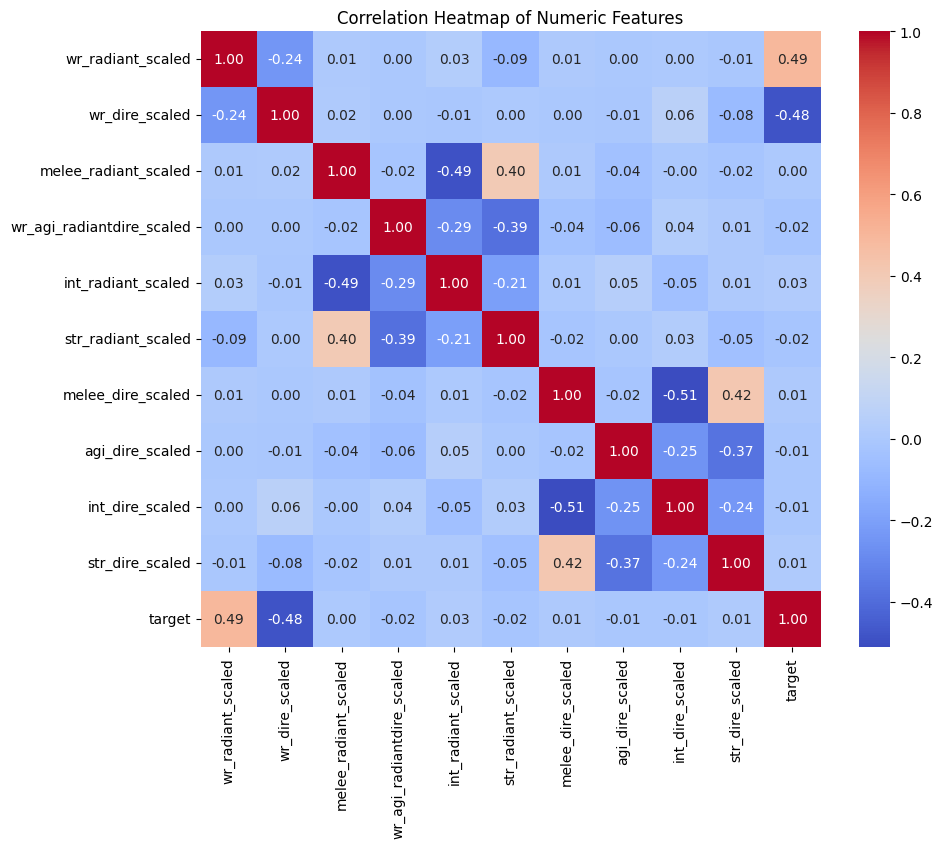

In [16]:
plt.figure(figsize=(10, 8))
corr_matrix = final_df[numeric_features+['target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()


In [17]:
df_melted = pd.melt(final_df, id_vars=['target'], value_vars=numeric_features, var_name='feature', value_name='value')
g = sns.FacetGrid(df_melted, col='feature', col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.scatterplot, 'value', 'target')
g.set_titles('{col_name} vs target')
g.set_xlabels('Значение признака')
g.set_ylabels('Target')
plt.savefig('facetgrid_numeric.png')
plt.close()

In [18]:
categorical_features = [i for i in final_df.columns.to_list() if i not in numeric_features+['target']]
categorical_features

['radiant_hero_1',
 'radiant_hero_2',
 'radiant_hero_3',
 'radiant_hero_4',
 'radiant_hero_5',
 'radiant_hero_6',
 'radiant_hero_7',
 'radiant_hero_8',
 'radiant_hero_9',
 'radiant_hero_10',
 'radiant_hero_11',
 'radiant_hero_12',
 'radiant_hero_13',
 'radiant_hero_14',
 'radiant_hero_15',
 'radiant_hero_16',
 'radiant_hero_17',
 'radiant_hero_18',
 'radiant_hero_19',
 'radiant_hero_20',
 'radiant_hero_21',
 'radiant_hero_22',
 'radiant_hero_23',
 'radiant_hero_25',
 'radiant_hero_26',
 'radiant_hero_27',
 'radiant_hero_28',
 'radiant_hero_29',
 'radiant_hero_30',
 'radiant_hero_31',
 'radiant_hero_32',
 'radiant_hero_33',
 'radiant_hero_34',
 'radiant_hero_35',
 'radiant_hero_36',
 'radiant_hero_37',
 'radiant_hero_38',
 'radiant_hero_39',
 'radiant_hero_40',
 'radiant_hero_41',
 'radiant_hero_42',
 'radiant_hero_43',
 'radiant_hero_44',
 'radiant_hero_45',
 'radiant_hero_46',
 'radiant_hero_47',
 'radiant_hero_48',
 'radiant_hero_49',
 'radiant_hero_50',
 'radiant_hero_51',
 'radiant

In [19]:
X = final_df.drop('target', axis=1)
y = final_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train_num, X_test_num = X_train[numeric_features], X_test[numeric_features]
X_train_cat, X_test_cat = X_train[categorical_features], X_test[categorical_features]
feature_names_num = X_train_num.columns

# Задание 3-4

In [21]:
def print_metrics_and_coeffs(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    return y_pred

def plot_feature_importance(coefs, feature_names, model_name):
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value, descending
    plt.barh(range(len(coefs)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(coefs)), feature_names[sorted_idx])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importance - {model_name}')
    plt.gca().invert_yaxis()  # Top-down order
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.close()


Linear Regression Results:
MSE: 0.1548
MAE: 0.3423
R²: 0.3798
Coefficients: [ 0.19857339 -0.19435571  0.00260158 -0.00409326  0.00927739  0.00491615
  0.01205515 -0.00631844  0.01135849 -0.01082065]
Intercept: 0.5217284673532074


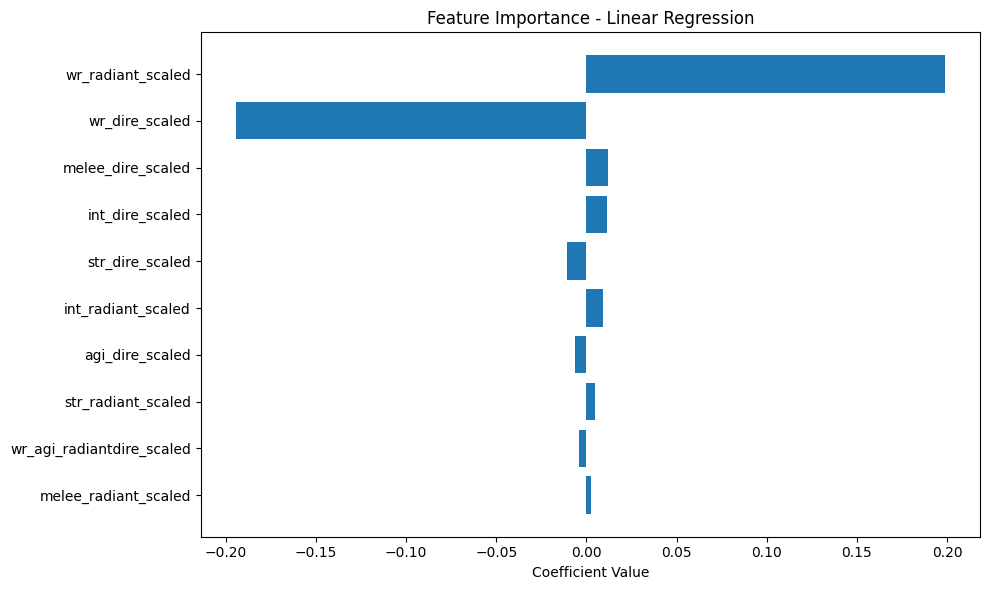

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train_num, y_train)
print_metrics_and_coeffs(lr_model, X_test_num, y_test, "Linear Regression")
plot_feature_importance(lr_model.coef_, feature_names_num, "Linear Regression")



Best Ridge Parameters: {'alpha': 10}

Ridge Regression Results:
MSE: 0.1548
MAE: 0.3423
R²: 0.3798
Coefficients: [ 0.1983346  -0.19411923  0.00260446 -0.00410407  0.00925785  0.00487804
  0.01199878 -0.0062968   0.01132243 -0.01076955]
Intercept: 0.5217270240027996


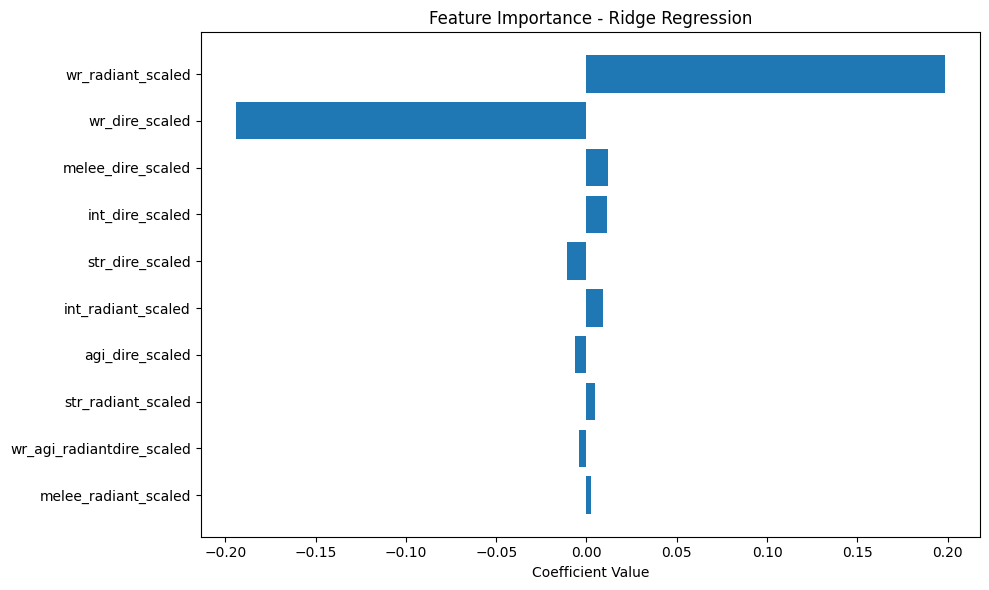

In [28]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_num, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"\nBest Ridge Parameters: {ridge_grid.best_params_}")
print_metrics_and_coeffs(best_ridge, X_test_num, y_test, "Ridge Regression")
plot_feature_importance(best_ridge.coef_, feature_names_num, "Ridge Regression")


Best LASSO Parameters: {'alpha': 0.001}

LASSO Regression Results:
MSE: 0.1548
MAE: 0.3427
R²: 0.3796
Coefficients: [ 0.19792787 -0.19322831  0.00104122 -0.00394386  0.00727812  0.00420276
  0.00940155 -0.0048805   0.00979742 -0.0085304 ]
Intercept: 0.5216982711222097


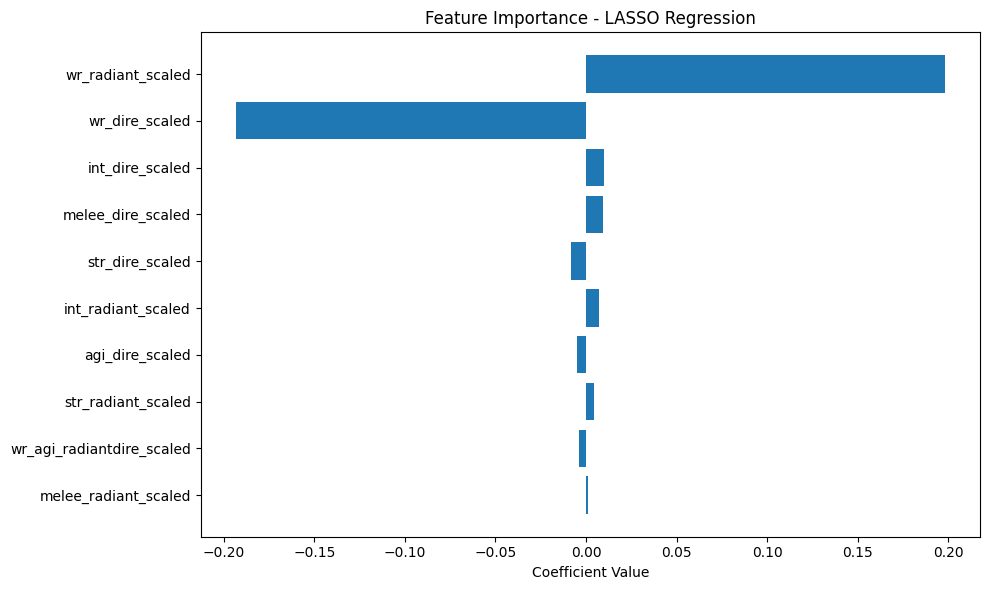

In [29]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_num, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"\nBest LASSO Parameters: {lasso_grid.best_params_}")
print_metrics_and_coeffs(best_lasso, X_test_num, y_test, "LASSO Regression")
plot_feature_importance(best_lasso.coef_, feature_names_num, "LASSO Regression")


Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}

Elastic Net Regression Results:
MSE: 0.1549
MAE: 0.3431
R²: 0.3795
Coefficients: [ 0.19650136 -0.19183189  0.00108569 -0.00399315  0.00720145  0.00398451
  0.0091244  -0.00477433  0.00961104 -0.00827416]
Intercept: 0.5216902221528704


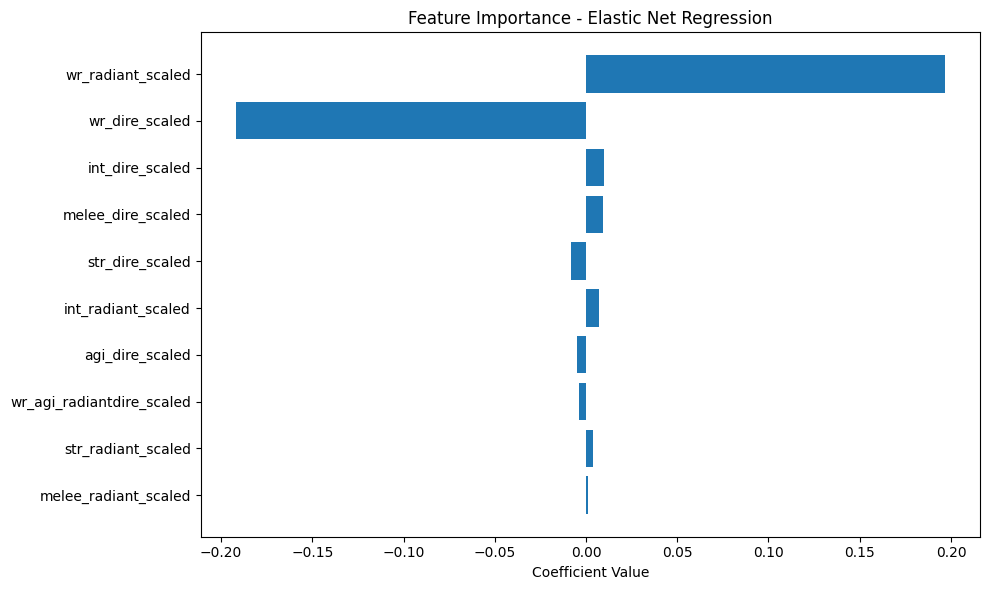

In [30]:
enet_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
enet_grid = GridSearchCV(ElasticNet(), enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train_num, y_train)
best_enet = enet_grid.best_estimator_
print(f"\nBest Elastic Net Parameters: {enet_grid.best_params_}")
print_metrics_and_coeffs(best_enet, X_test_num, y_test, "Elastic Net Regression")
plot_feature_importance(best_enet.coef_, feature_names_num, "Elastic Net Regression")

In [31]:
best_models = {
    'LinearRegression': lr_model,
    'Ridge': best_ridge,
    'LASSO': best_lasso,
    'ElasticNet': best_enet
}

# Задание 5 выполнялось в задании 2

# Задание 6

In [35]:
def print_metrics_and_coeffs(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    return y_pred

def plot_feature_importance(coefs, feature_names, model_name):
    plt.figure(figsize=(10, 60))
    sorted_idx = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value, descending
    plt.barh(range(len(coefs)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(coefs)), feature_names[sorted_idx])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importance - {model_name}')
    plt.gca().invert_yaxis()  # Top-down order
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.close()

In [ ]:
feature_names = X_train.columns


Linear Regression Results:
MSE: 0.1396
MAE: 0.3236
R²: 0.4407
Coefficients: [-1.03636480e+12 -4.41436741e+11  3.41224947e+11 -1.03636480e+12
  1.32881091e+12 -2.92053186e+11 -4.41436741e+11 -1.03636480e+12
  3.41224947e+11 -2.92053186e+11 -2.92053186e+11 -1.03636480e+12
  1.32881091e+12 -4.41436741e+11 -2.92053186e+11 -4.03086670e+11
  1.32881091e+12 -4.41436741e+11 -4.41436741e+11  3.41224947e+11
  3.41224947e+11  1.32881091e+12 -4.41436741e+11  1.32881091e+12
  1.32881091e+12  1.32881091e+12 -4.41436741e+11 -4.41436741e+11
  1.32881091e+12  1.32881091e+12 -1.03636480e+12  3.41224947e+11
  1.32881091e+12 -2.92053186e+11  1.32881091e+12  1.32881091e+12
 -4.03086670e+11  1.32881091e+12  3.41224947e+11 -1.03636480e+12
 -4.41436741e+11  1.32881091e+12 -1.03636480e+12  1.32881091e+12
 -2.92053186e+11 -2.92053186e+11 -2.92053186e+11 -4.41436741e+11
  3.41224947e+11 -4.03086670e+11  1.32881091e+12  1.32881091e+12
 -4.41436741e+11 -4.03086670e+11 -2.92053186e+11 -4.41436741e+11
  1.32881091e

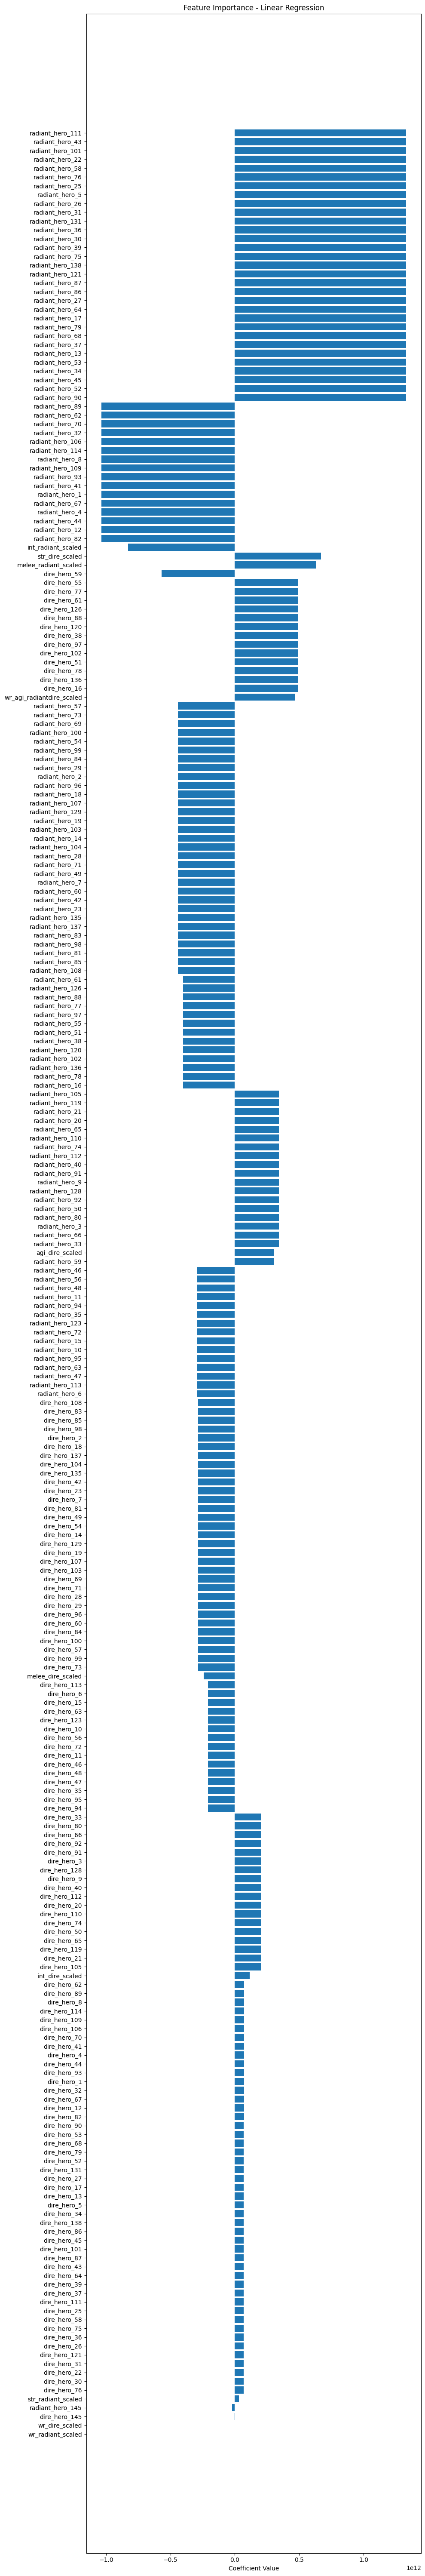

In [ ]:
# плохо работает на тестовом, не понимаю почему best_ridge.alpha
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print_metrics_and_coeffs(lr_model, X_train, y_train, "Linear Regression")
plot_feature_importance(lr_model.coef_, feature_names, "Linear Regression")


Best Ridge Parameters: {'alpha': 100}

Ridge Regression Results:
MSE: 0.1516
MAE: 0.3404
R²: 0.3924
Coefficients: [ 3.11315197e-03 -1.94368309e-03 -2.99253676e-02  1.28318604e-03
  6.75643183e-03  3.67594674e-02  2.41595110e-03 -1.94400964e-02
 -2.73137093e-03  9.41439557e-03 -7.43890460e-03  2.48175057e-02
 -2.16438503e-02 -7.28776041e-03  1.92285551e-03  3.03634507e-02
 -2.27197522e-02 -1.17351028e-02 -6.50396274e-03  3.22980958e-02
  3.09935921e-02  3.69966696e-02  1.47999177e-02  2.53665432e-02
  2.59004453e-02 -6.57960728e-03  6.61356038e-03 -1.70807551e-02
  8.90125530e-03  2.38840022e-02 -2.02254758e-02 -8.14797216e-02
 -3.72881882e-02  9.45865596e-03  1.29800176e-02 -1.73250222e-02
  7.20027113e-03  1.81352313e-02  1.51109064e-03  3.26029299e-03
  9.49604084e-03  3.30801683e-02  5.20454005e-02 -4.61596426e-02
 -4.04575548e-02  2.64928146e-02 -2.98496451e-02  1.03865198e-02
 -2.01763224e-02 -5.41824514e-03 -6.93488489e-02 -2.91284525e-02
 -3.17142178e-02 -3.39204909e-03 -1.6542

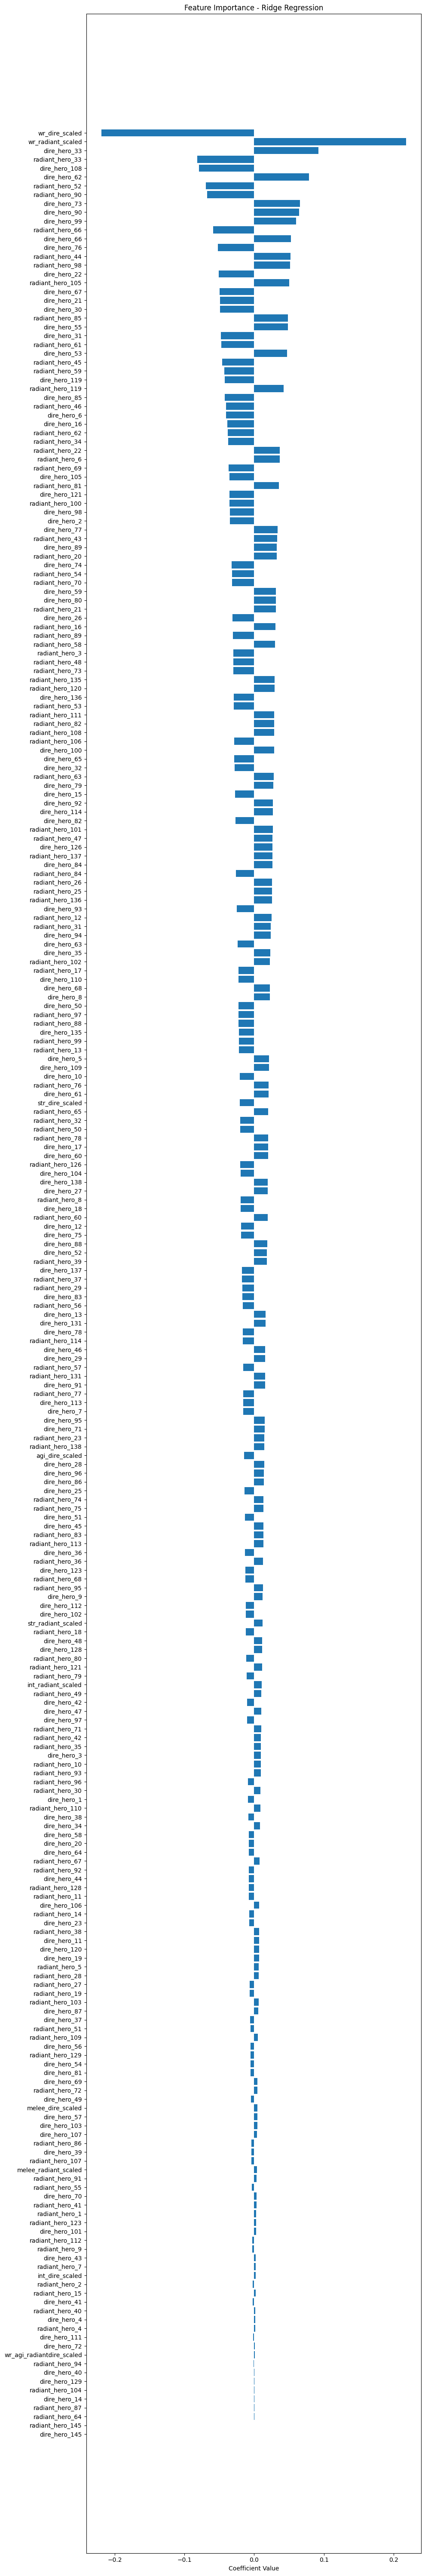

In [38]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
print(f"\nBest Ridge Parameters: {ridge_grid.best_params_}")
print_metrics_and_coeffs(best_ridge, X_test, y_test, "Ridge Regression")
plot_feature_importance(best_ridge.coef_, feature_names, "Ridge Regression")


Best LASSO Parameters: {'alpha': 0.001}

LASSO Regression Results:
MSE: 0.1523
MAE: 0.3411
R²: 0.3898
Coefficients: [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.03544550e-03  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -1.39259159e-02 -0.00000000e+00 -0.00000000e+00  4.17687763e-03
 -1.25887994e-02 -0.00000000e+00 -0.00000000e+00  2.19916206e-04
  6.03918389e-03  2.38436366e-02  0.00000000e+00  7.85702216e-03
  1.15047022e-02 -0.00000000e+00  0.00000000e+00 -2.94847661e-03
  0.00000000e+00  8.77538220e-03 -0.00000000e+00 -9.87485212e-02
 -2.46653006e-02  0.00000000e+00  0.00000000e+00 -7.00015179e-03
  0.00000000e+00  1.76133037e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.29818131e-02 -3.97709818e-02
 -3.46521029e-02  0.00000000e+00 -1.41034716e-02  2.77914837e-03
 -0.00000000e+00 -0.00000000e+00 -7.13404598e-02 -1.52145758e-02
 -1.97723082e-02 -0.00000000e+00 -0.00

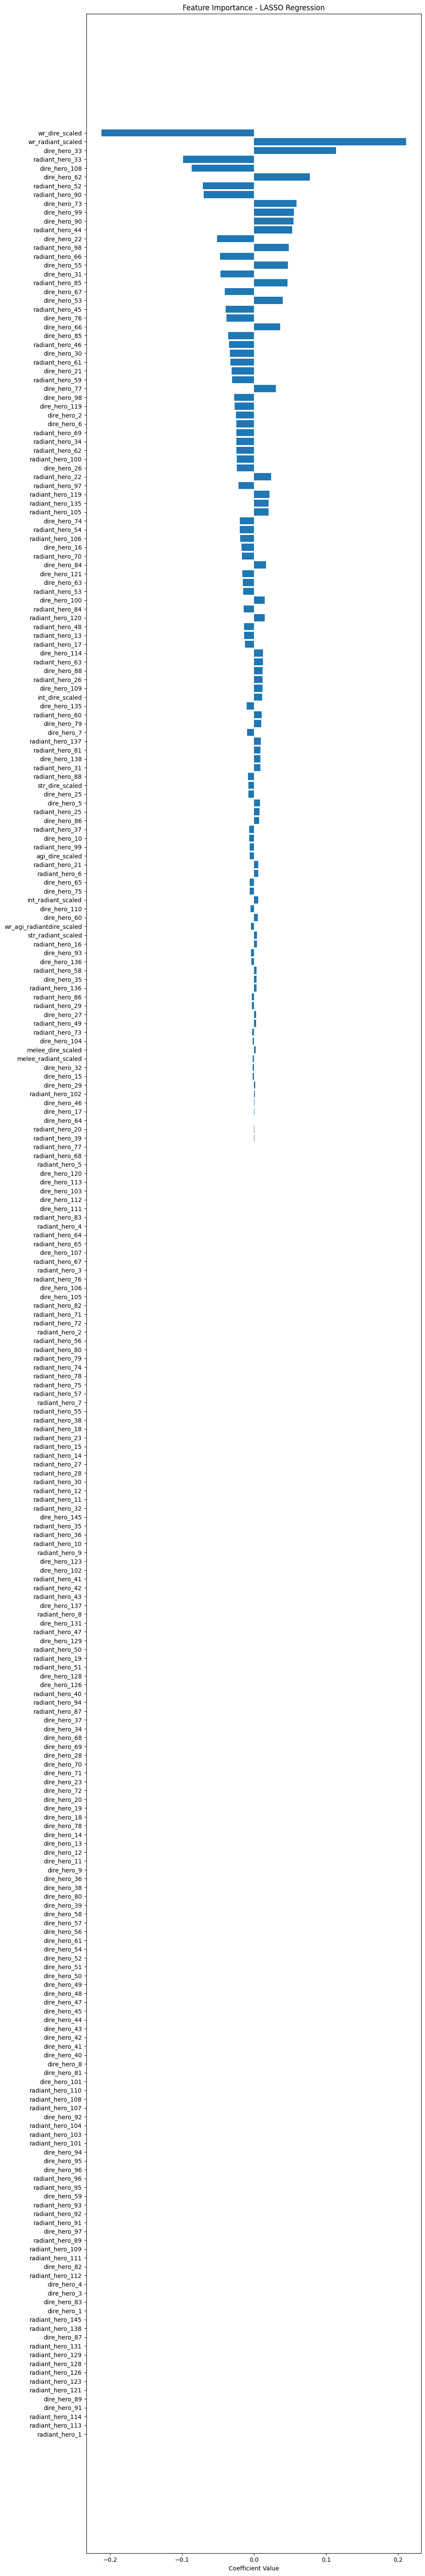

In [41]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
print(f"\nBest LASSO Parameters: {lasso_grid.best_params_}")
print_metrics_and_coeffs(best_lasso, X_test, y_test, "LASSO Regression")
plot_feature_importance(best_lasso.coef_, feature_names, "LASSO Regression")


Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}

Elastic Net Regression Results:
MSE: 0.1528
MAE: 0.3420
R²: 0.3880
Coefficients: [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.66814727e-03  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -8.52137731e-03 -0.00000000e+00 -0.00000000e+00  2.23124737e-03
 -6.93598734e-03 -0.00000000e+00 -0.00000000e+00  3.38725738e-04
  4.61413571e-03  2.21144169e-02  0.00000000e+00  9.21163068e-03
  1.03350204e-02 -0.00000000e+00  0.00000000e+00 -1.48134440e-03
  0.00000000e+00  8.30369252e-03 -0.00000000e+00 -6.46947867e-02
 -1.34295913e-02  0.00000000e+00  0.00000000e+00 -3.51216260e-03
  0.00000000e+00  2.00367459e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.76827865e-02 -2.85731605e-02
 -2.73578291e-02  0.00000000e+00 -8.22863378e-03  2.28395067e-03
 -0.00000000e+00 -0.00000000e+00 -5.29063112e-02 -8.70844130e-03
 -1.798550

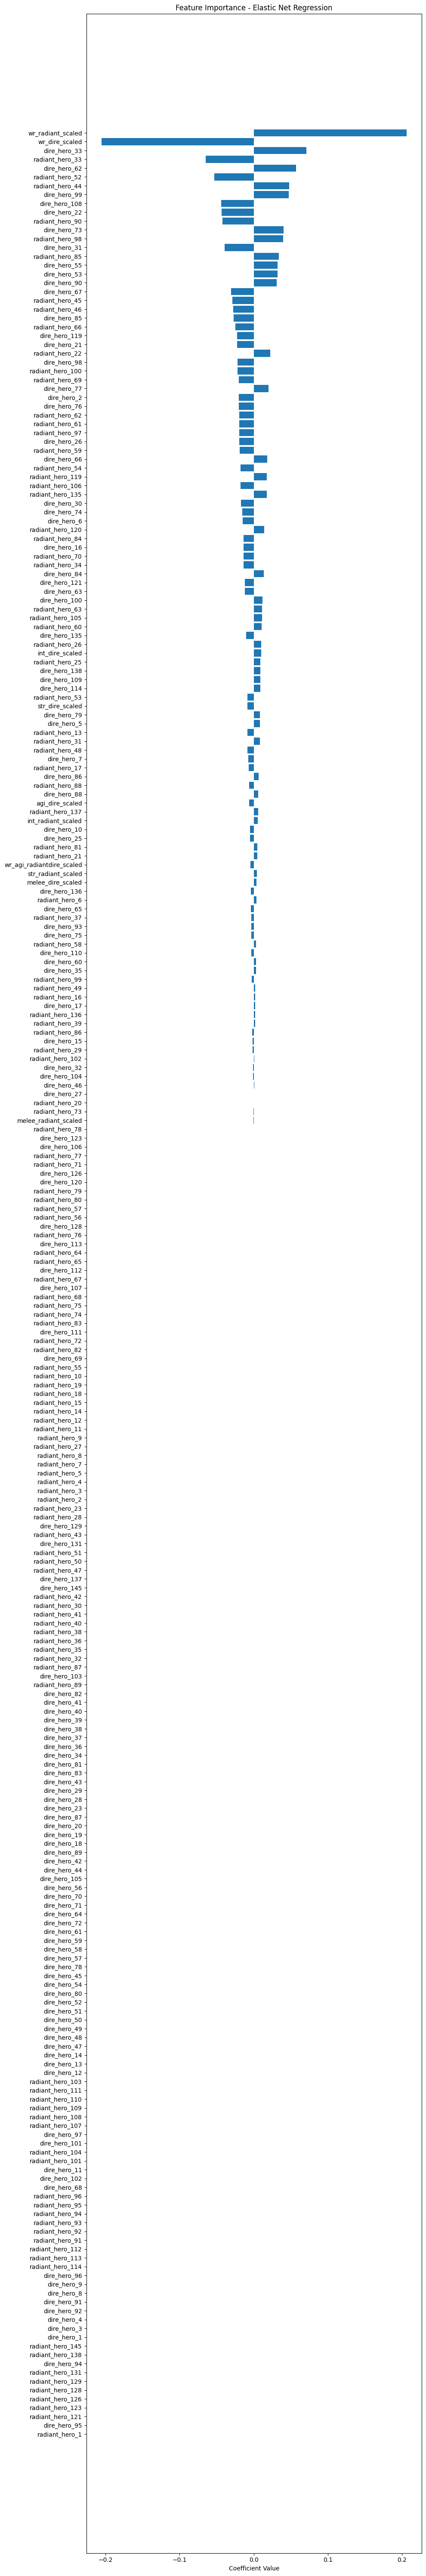

In [42]:
enet_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
enet_grid = GridSearchCV(ElasticNet(), enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train, y_train)
best_enet = enet_grid.best_estimator_
print(f"\nBest Elastic Net Parameters: {enet_grid.best_params_}")
print_metrics_and_coeffs(best_enet, X_test, y_test, "Elastic Net Regression")
plot_feature_importance(best_enet.coef_, feature_names, "Elastic Net Regression")

In [53]:
def print_metrics_and_coeffs(model, X, y, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    
    return mse, mae, r2

In [55]:
lr_metrics = print_metrics_and_coeffs(lr_model, X_test, y_test, "Linear Regression")
ridge_metrics = print_metrics_and_coeffs(best_ridge, X_test, y_test, "Ridge Regression")
lasso_metrics = print_metrics_and_coeffs(best_lasso, X_test, y_test, "LASSO Regression")
enet_metrics = print_metrics_and_coeffs(best_enet, X_test, y_test, "Elastic Net Regression")


Linear Regression Results:
MSE: 615097466557354213376.0000
MAE: 606895243.5742
R²: -2464475970746873020416.0000
Coefficients: [-1.03636480e+12 -4.41436741e+11  3.41224947e+11 -1.03636480e+12
  1.32881091e+12 -2.92053186e+11 -4.41436741e+11 -1.03636480e+12
  3.41224947e+11 -2.92053186e+11 -2.92053186e+11 -1.03636480e+12
  1.32881091e+12 -4.41436741e+11 -2.92053186e+11 -4.03086670e+11
  1.32881091e+12 -4.41436741e+11 -4.41436741e+11  3.41224947e+11
  3.41224947e+11  1.32881091e+12 -4.41436741e+11  1.32881091e+12
  1.32881091e+12  1.32881091e+12 -4.41436741e+11 -4.41436741e+11
  1.32881091e+12  1.32881091e+12 -1.03636480e+12  3.41224947e+11
  1.32881091e+12 -2.92053186e+11  1.32881091e+12  1.32881091e+12
 -4.03086670e+11  1.32881091e+12  3.41224947e+11 -1.03636480e+12
 -4.41436741e+11  1.32881091e+12 -1.03636480e+12  1.32881091e+12
 -2.92053186e+11 -2.92053186e+11 -2.92053186e+11 -4.41436741e+11
  3.41224947e+11 -4.03086670e+11  1.32881091e+12  1.32881091e+12
 -4.41436741e+11 -4.03086670

In [56]:
models = {
    'Linear Regression': (lr_model, lr_metrics[2]),
    'Ridge': (best_ridge, ridge_metrics[2]),
    'LASSO': (best_lasso, lasso_metrics[2]),
    'Elastic Net': (best_enet, enet_metrics[2])
}
best_model_name, (best_model, best_r2) = max(models.items(), key=lambda x: x[1][1])
print(f"\nBest model selected: {best_model_name} with R² = {best_r2:.4f}")

if best_model_name == 'Linear Regression':
    estimator = LinearRegression()
elif best_model_name == 'Ridge':
    estimator = Ridge(alpha=best_ridge.alpha)
elif best_model_name == 'LASSO':
    estimator = Lasso(alpha=best_lasso.alpha)
elif best_model_name == 'Elastic Net':
    estimator = ElasticNet(alpha=best_enet.alpha, l1_ratio=best_enet.l1_ratio)



Best model selected: Ridge with R² = 0.3924


In [57]:
selector = RFECV(estimator, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]
print(f"Выбранные признаки: {list(selected_features)}")

Выбранные признаки: ['radiant_hero_3', 'radiant_hero_6', 'radiant_hero_8', 'radiant_hero_12', 'radiant_hero_13', 'radiant_hero_16', 'radiant_hero_17', 'radiant_hero_20', 'radiant_hero_21', 'radiant_hero_22', 'radiant_hero_23', 'radiant_hero_25', 'radiant_hero_26', 'radiant_hero_31', 'radiant_hero_32', 'radiant_hero_33', 'radiant_hero_34', 'radiant_hero_39', 'radiant_hero_42', 'radiant_hero_43', 'radiant_hero_44', 'radiant_hero_45', 'radiant_hero_46', 'radiant_hero_47', 'radiant_hero_48', 'radiant_hero_49', 'radiant_hero_50', 'radiant_hero_52', 'radiant_hero_53', 'radiant_hero_54', 'radiant_hero_56', 'radiant_hero_57', 'radiant_hero_58', 'radiant_hero_59', 'radiant_hero_60', 'radiant_hero_61', 'radiant_hero_62', 'radiant_hero_63', 'radiant_hero_65', 'radiant_hero_66', 'radiant_hero_69', 'radiant_hero_70', 'radiant_hero_71', 'radiant_hero_73', 'radiant_hero_75', 'radiant_hero_76', 'radiant_hero_77', 'radiant_hero_78', 'radiant_hero_80', 'radiant_hero_81', 'radiant_hero_82', 'radiant_hero


Metrics for Ridge after RFE on test set:
MSE: 0.1522
MAE: 0.3414
R²: 0.3901


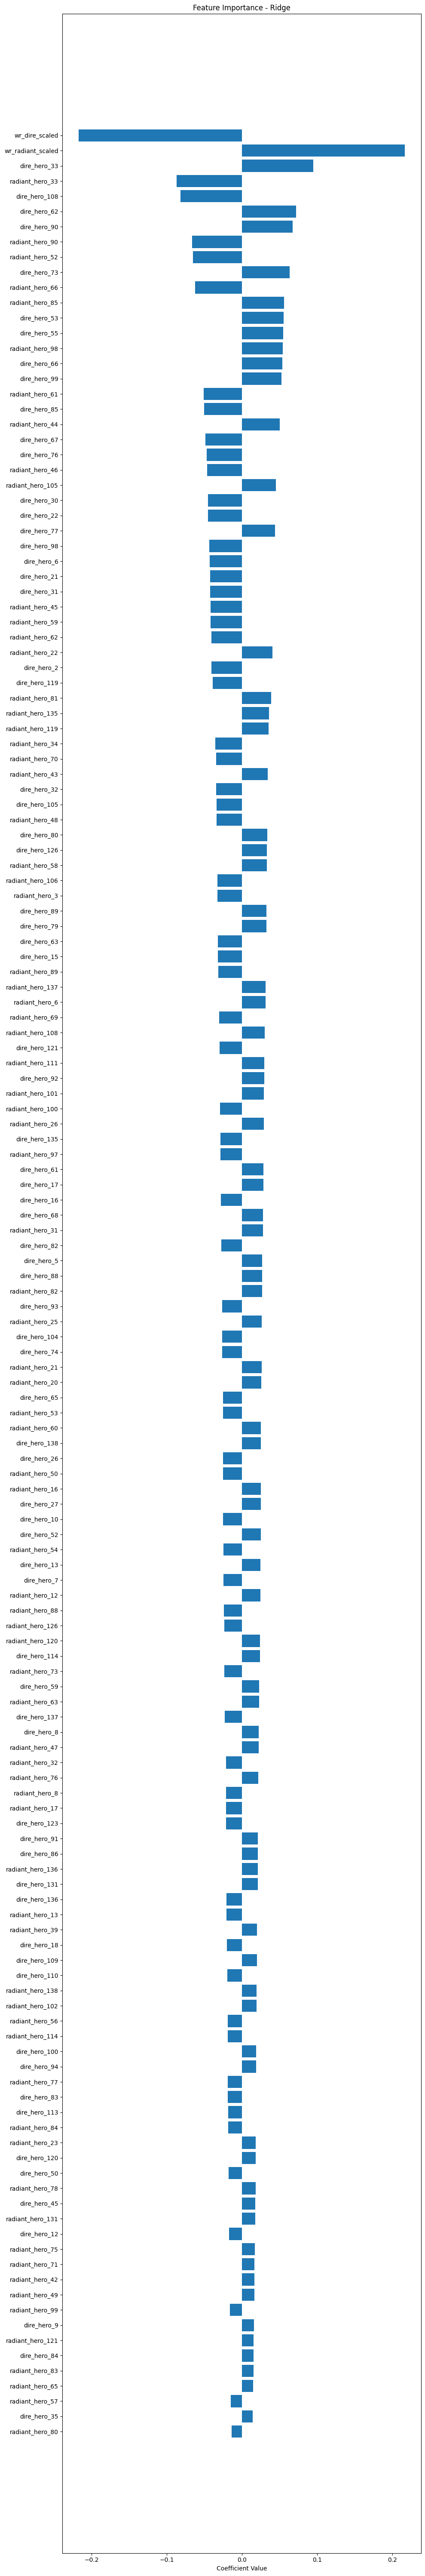

In [59]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
best_model.fit(X_train_selected, y_train)



y_pred_selected = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred_selected)
mae = mean_absolute_error(y_test, y_pred_selected)
r2 = r2_score(y_test, y_pred_selected)
print(f"\nMetrics for {best_model_name} after RFE on test set:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

plot_feature_importance(best_model.coef_, selected_features, best_model_name)

# Задание 7